In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap

def SHAP(bst, X_train):
    # SHAP値を計算
    explainer = shap.TreeExplainer(bst)
    shap_values = explainer.shap_values(X_train)
    
    # SHAP値をプロット
    shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1])
    return

def BFI(bst):
    # ビルトインのフィーチャーインポータンスを取得
    feature_importances = bst.get_score(importance_type='weight')

    # 特徴量の名前とインポータンスをプリント
    for key, value in feature_importances.items():
        print(f"Feature: {key}, Importance: {value}")

    # フィーチャーインポータンスをプロット
    xgb.plot_importance(bst)
    plt.show()
    return

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0
    }
    
    """   # モデルのパラメータを設定(GPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 4,
        'eta': 0.1,
        'max_depth': 12,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }"""

    # データをpandas.DataFrame形式で保存
    X_train_df = X_train.copy()

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred.round())
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred.round())
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    SHAP(bst, X_train_df)
    #BFI(bst)
    return

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df


In [2]:
raw = 1 #rawデータならば１、Bandなら０,

# 1秒ごとのデータに分割
n_samples_per_second = 256  # 256Hzのサンプリングレート
total_seconds = 10  # 全体の秒数

# データの読み込み
if(raw):
    #df = pd.read_csv('Raw.csv')
    df = pd.read_csv('Raw_ICA.csv')
else:
    df = pd.read_csv('Band.csv')
    #df = pd.read_csv('emotion.csv')
    
# チャンネルごとに正規化
scaler = StandardScaler()
for column in df.columns[:-1]:  # 'State'列を除くすべての列
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))

In [3]:
"""
#１秒ごとに分割
# ラベルの作成（5秒閉じ、5秒開け）
labels_close = [0] * 5 *64 
labels_open = [1] * 5 * 64
labels = labels_close + labels_open

#labels = df.iloc[:, -1]

#14chデータ
n_samples_per_second = 4
total_seconds = 10  # 全体の秒数
#total_seconds = 3242  # 全体の秒数

# データとラベルを1秒ごとに分割
#X = np.array([df.iloc[i*n_samples_per_second:(i+1)*n_samples_per_second, :-1].values for i in range(total_seconds)])

X = np.array([df.iloc[i*n_samples_per_second:(i+1)*n_samples_per_second, :-1].values for i in range(total_seconds*64)])
#labels = np.array([stats.mode(y[i*n_samples_per_second:(i+1)*n_samples_per_second])[0][0] for i in range(total_seconds*64)])


# 1秒ごとのデータの平均を取得
X = X.mean(axis=1)

#XGBoost
XGBoost(X, labels)

#plot
#plot_importance(raw, model1)

"""

'\n#１秒ごとに分割\n# ラベルの作成（5秒閉じ、5秒開け）\nlabels_close = [0] * 5 *64 \nlabels_open = [1] * 5 * 64\nlabels = labels_close + labels_open\n\n#labels = df.iloc[:, -1]\n\n#14chデータ\nn_samples_per_second = 4\ntotal_seconds = 10  # 全体の秒数\n#total_seconds = 3242  # 全体の秒数\n\n# データとラベルを1秒ごとに分割\n#X = np.array([df.iloc[i*n_samples_per_second:(i+1)*n_samples_per_second, :-1].values for i in range(total_seconds)])\n\nX = np.array([df.iloc[i*n_samples_per_second:(i+1)*n_samples_per_second, :-1].values for i in range(total_seconds*64)])\n#labels = np.array([stats.mode(y[i*n_samples_per_second:(i+1)*n_samples_per_second])[0][0] for i in range(total_seconds*64)])\n\n\n# 1秒ごとのデータの平均を取得\nX = X.mean(axis=1)\n\n#XGBoost\nXGBoost(X, labels)\n\n#plot\n#plot_importance(raw, model1)\n\n'

[0]	train-logloss:0.67813	eval-logloss:0.68272
[1]	train-logloss:0.66208	eval-logloss:0.66978
[2]	train-logloss:0.65103	eval-logloss:0.66220
[3]	train-logloss:0.63788	eval-logloss:0.65077
[4]	train-logloss:0.62930	eval-logloss:0.64425
[5]	train-logloss:0.61834	eval-logloss:0.63349
[6]	train-logloss:0.61088	eval-logloss:0.62720
[7]	train-logloss:0.60451	eval-logloss:0.62344
[8]	train-logloss:0.59734	eval-logloss:0.61836
[9]	train-logloss:0.58589	eval-logloss:0.60904
[10]	train-logloss:0.57984	eval-logloss:0.60437
[11]	train-logloss:0.57398	eval-logloss:0.60086
[12]	train-logloss:0.56860	eval-logloss:0.59651
[13]	train-logloss:0.56361	eval-logloss:0.59326
[14]	train-logloss:0.55667	eval-logloss:0.58749
[15]	train-logloss:0.55120	eval-logloss:0.58316
[16]	train-logloss:0.54411	eval-logloss:0.57674
[17]	train-logloss:0.53934	eval-logloss:0.57394
[18]	train-logloss:0.53485	eval-logloss:0.57130
[19]	train-logloss:0.52795	eval-logloss:0.56551
[20]	train-logloss:0.52550	eval-logloss:0.56341
[2

[170]	train-logloss:0.20075	eval-logloss:0.37702
[171]	train-logloss:0.19991	eval-logloss:0.37668
[172]	train-logloss:0.19898	eval-logloss:0.37602
[173]	train-logloss:0.19762	eval-logloss:0.37553
[174]	train-logloss:0.19714	eval-logloss:0.37576
[175]	train-logloss:0.19621	eval-logloss:0.37499
[176]	train-logloss:0.19534	eval-logloss:0.37387
[177]	train-logloss:0.19498	eval-logloss:0.37358
[178]	train-logloss:0.19431	eval-logloss:0.37319
[179]	train-logloss:0.19336	eval-logloss:0.37306
[180]	train-logloss:0.19266	eval-logloss:0.37257
[181]	train-logloss:0.19212	eval-logloss:0.37231
[182]	train-logloss:0.19042	eval-logloss:0.37214
[183]	train-logloss:0.18864	eval-logloss:0.37225
[184]	train-logloss:0.18707	eval-logloss:0.37089
[185]	train-logloss:0.18598	eval-logloss:0.37010
[186]	train-logloss:0.18480	eval-logloss:0.36942
[187]	train-logloss:0.18289	eval-logloss:0.36877
[188]	train-logloss:0.18222	eval-logloss:0.36893
[189]	train-logloss:0.18135	eval-logloss:0.36897
[190]	train-logloss:

[338]	train-logloss:0.09455	eval-logloss:0.33653
[339]	train-logloss:0.09415	eval-logloss:0.33674
[340]	train-logloss:0.09377	eval-logloss:0.33669
[341]	train-logloss:0.09332	eval-logloss:0.33609
[342]	train-logloss:0.09313	eval-logloss:0.33597
[343]	train-logloss:0.09260	eval-logloss:0.33514
[344]	train-logloss:0.09220	eval-logloss:0.33497
[345]	train-logloss:0.09167	eval-logloss:0.33512
[346]	train-logloss:0.09140	eval-logloss:0.33517
[347]	train-logloss:0.09111	eval-logloss:0.33499
[348]	train-logloss:0.09093	eval-logloss:0.33556
[349]	train-logloss:0.09020	eval-logloss:0.33465
[350]	train-logloss:0.09004	eval-logloss:0.33474
[351]	train-logloss:0.08930	eval-logloss:0.33453
[352]	train-logloss:0.08902	eval-logloss:0.33406
[353]	train-logloss:0.08849	eval-logloss:0.33421
[354]	train-logloss:0.08840	eval-logloss:0.33430
[355]	train-logloss:0.08786	eval-logloss:0.33421
[356]	train-logloss:0.08777	eval-logloss:0.33454
[357]	train-logloss:0.08749	eval-logloss:0.33468
[358]	train-logloss:

[506]	train-logloss:0.04797	eval-logloss:0.31978
[507]	train-logloss:0.04792	eval-logloss:0.31991
[508]	train-logloss:0.04769	eval-logloss:0.31997
[509]	train-logloss:0.04758	eval-logloss:0.32003
[510]	train-logloss:0.04747	eval-logloss:0.32032
[511]	train-logloss:0.04736	eval-logloss:0.32023
[512]	train-logloss:0.04729	eval-logloss:0.32058
[513]	train-logloss:0.04718	eval-logloss:0.32072
[514]	train-logloss:0.04712	eval-logloss:0.32084
[515]	train-logloss:0.04706	eval-logloss:0.32113
[516]	train-logloss:0.04696	eval-logloss:0.32097
[517]	train-logloss:0.04687	eval-logloss:0.32113
[518]	train-logloss:0.04683	eval-logloss:0.32121
[519]	train-logloss:0.04671	eval-logloss:0.32119
[520]	train-logloss:0.04639	eval-logloss:0.32065
[521]	train-logloss:0.04633	eval-logloss:0.32047
[522]	train-logloss:0.04607	eval-logloss:0.32051
[523]	train-logloss:0.04581	eval-logloss:0.32058
[524]	train-logloss:0.04568	eval-logloss:0.32065
[525]	train-logloss:0.04556	eval-logloss:0.32051
[526]	train-logloss:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


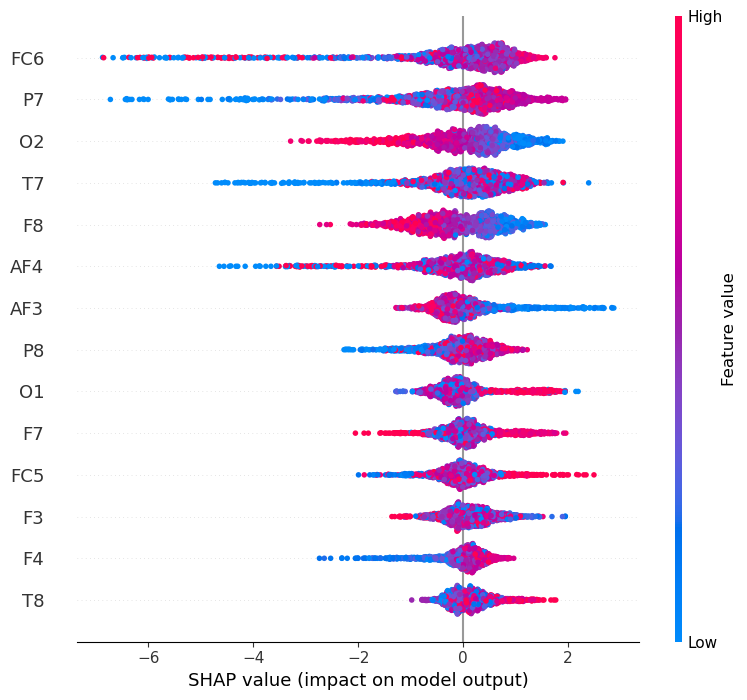

In [4]:
# Hzごと
# 特徴量と目標変数を抽出する
X = df.drop('State', axis=1)  # 'State'以外の列すべてを特徴量とします
y = df['State']  # 'State'を目標変数とします

#XGBoost
XGBoost(X, y)

#plot